In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy.integrate import solve_ivp
import pickle
from pathlib import Path

In [2]:
header = {
    "seed": 42,
    "scipy_version": scipy.__version__,
    "numpy_version": np.__version__,
}
header

{'seed': 42, 'scipy_version': '1.15.3', 'numpy_version': '1.26.4'}

Things to consider:
- Each equation has several parameters that can be adjusted to create different behavior
- The initial condition governs some of the differences between different systems

## Dynamical Systems

In [3]:
def harmonic_oscillator(t, y, omega):
    x, v = y
    return np.array([v, -omega**2 * x])

def damped_harmonic_oscillator(t, y, zeta, omega):
    x, v = y
    return [v, -2 * zeta * omega * v - omega**2 * x]

def sm_damper_forcing(t, y, zeta, omega, gamma, alpha):
    x, v = y
    return [v, -2 * zeta * omega * v - omega**2 * x + gamma * np.cos(alpha * x)]

def duffing_oscillator(t, y, zeta, omega, beta, gamma, alpha):
    x, v = y
    return [v, -2 * zeta * omega * v - omega**2 * x - beta * x**3 + gamma * np.cos(alpha * x)]

def van_der_pol(t, y, mu):
    x, v = y
    return [v, mu * (1 - x**2) * v - x]

In [4]:
def harmonic_params(rng):
    return {'omega': rng.uniform(2, 6)}

def under_damped_harmonic_params(rng):
    return {'zeta': rng.uniform(0.02, 0.25),
            'omega': rng.uniform(2, 6)}

def spring_mass_forcing_params(rng):
    return {'zeta': rng.uniform(0.02, 0.15),
            'omega': rng.uniform(2, 6),
            'gamma': rng.uniform(1, 3),
            'alpha': rng.uniform(1, 3)}

def duffing_params(rng):
    return {'zeta' : rng.uniform(0.02, 0.15),
            'omega': rng.uniform(1, 3),
            'beta' : rng.uniform(0.5, 1.5),
            'gamma': rng.uniform(0.5, 1.5),
            'alpha': rng.uniform(1, 3)}

def vdp_params(rng):
    return {'mu': rng.uniform(0.5, 2)}

In [5]:
harm_d = 2
damped_harm_d = 2
sm_damp_d = 2
duffing_d = 2
van_der_pol_d = 2

In [6]:
systems = {
    'harmomic_oscillator' : (harmonic_oscillator, harmonic_params, harm_d),
    'under_damped_harmonic_oscillator' : (damped_harmonic_oscillator, under_damped_harmonic_params, damped_harm_d),
    'spring_mass_with_forcing' : (sm_damper_forcing, spring_mass_forcing_params, sm_damp_d),
    'duffing_oscillator' : (duffing_oscillator, duffing_params, duffing_d),
    'van_der_pol_oscillator' : (van_der_pol, vdp_params, van_der_pol_d)
          }

In [7]:
def create_dataset(n,start,end,num_series,seed=42):
    rng = np.random.default_rng(seed)
    
    t_eval = np.linspace(start,end,n)
    dataset = {system : [] for system in systems.keys()}
    
    for system, (ode, sampler, dim) in systems.items():
        for _ in range(num_series):
            y0 = [rng.uniform(-5,5), rng.uniform(-5,5)]
            params = sampler(rng)
            
            def wrapped_ode(t,y): return ode(t,y,**params)
        
            sol = solve_ivp(wrapped_ode, [start,end], y0, t_eval=t_eval)
        
            record = {
                'params' : params,
                'y0' : y0,
                'start' : start,
                'end' : end,
                't' : sol.t,
                'y' : sol.y
            }
        
            dataset[system].append(record)

    return dataset

In [8]:
n = 2000
begin = 0
end = 10
num_series = 100
seed = 42

dataset = create_dataset(n,begin,end,num_series,seed=seed)

In [9]:
len(systems)

5

In [25]:
path = Path().resolve().parents[0] / 'data' / '1-dimensional-systems' / f"dataset_{len(systems)}_class_{num_series}_samples.pkl"

with open(path, 'wb') as f:
    pickle.dump(dataset, f)

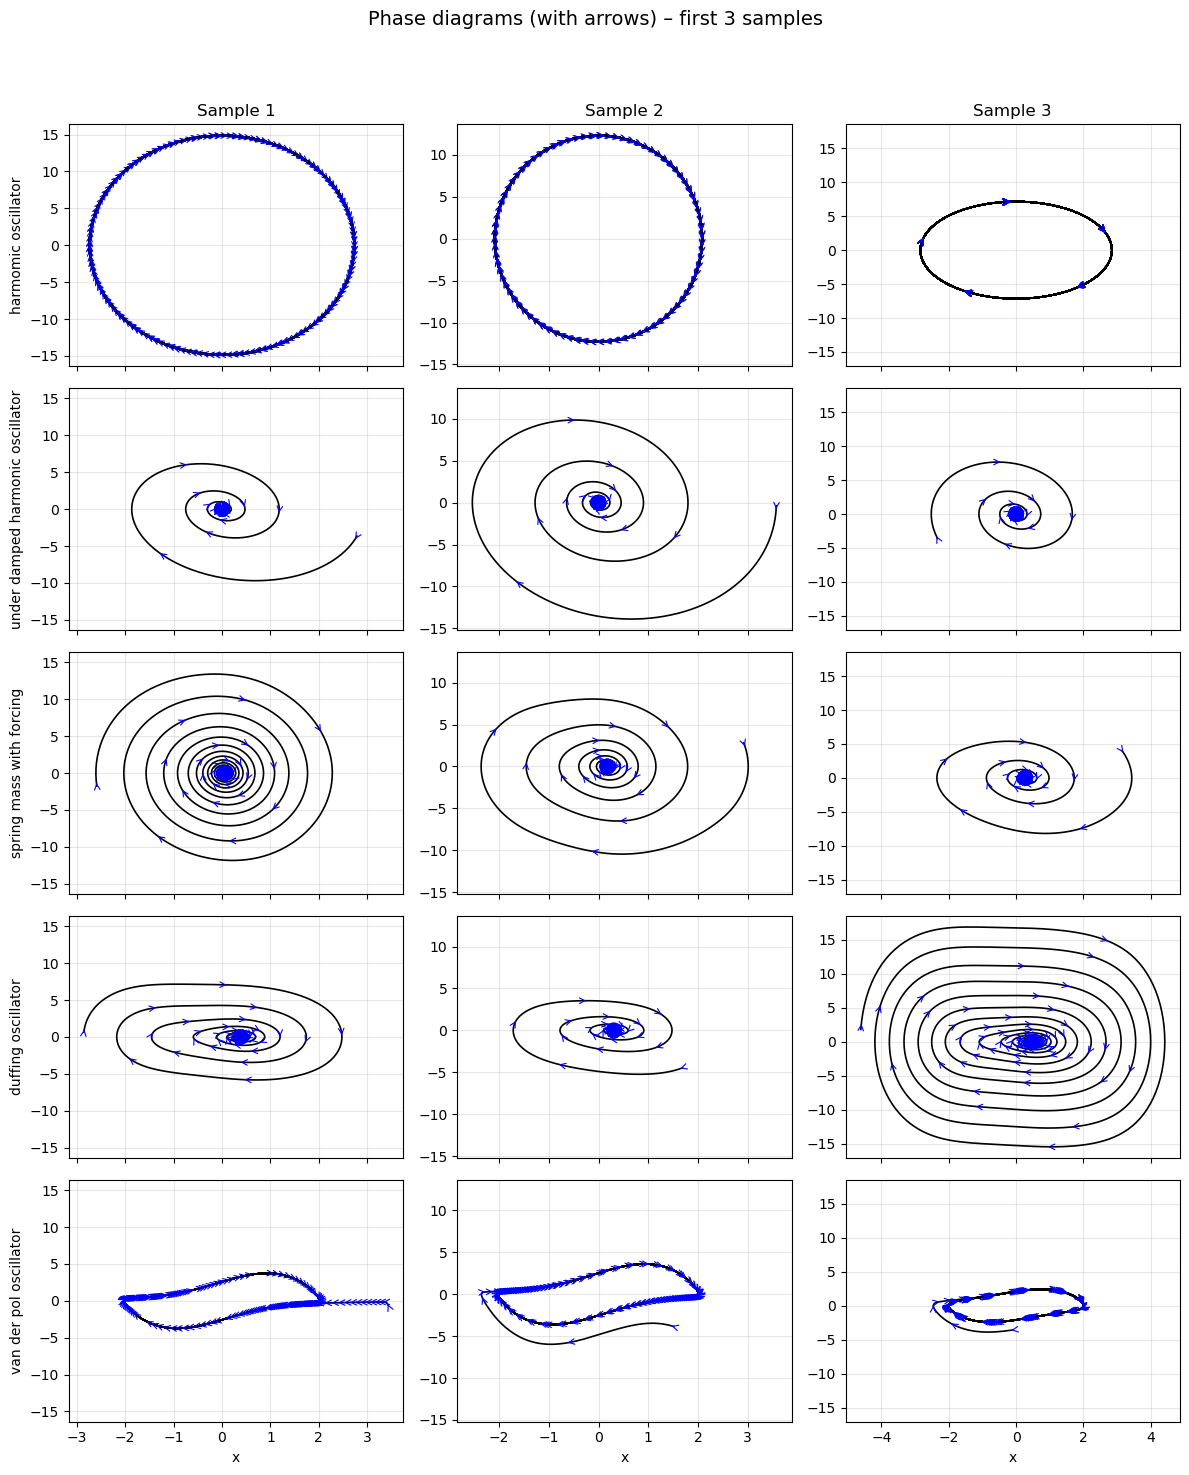

In [26]:
n_examples = 3                          # first N samples of each system
skip       = 50                         # draw an arrow every `skip` points
systems    = list(dataset.keys())
rows, cols = len(systems), n_examples
fig, axes  = plt.subplots(rows, cols,
                          figsize=(4*cols, 3*rows),
                          sharex='col', sharey='col')
fig.suptitle(f'Phase diagrams (with arrows) – first {n_examples} samples', fontsize=14)

for r, sys in enumerate(systems):
    records = dataset[sys][:n_examples]

    for c, rec in enumerate(records):
        x, v = rec['y']                        # position & velocity
        ax   = axes[r, c] if rows > 1 else axes[c]

        # main trajectory line
        ax.plot(x, v, lw=1.2, color='black')

        # add arrows along the trajectory
        for j in range(0, len(x) - 1, skip):
            ax.annotate("",
                        xy=(x[j + 1], v[j + 1]),
                        xytext=(x[j], v[j]),
                        arrowprops=dict(arrowstyle="->",
                                        color="blue",
                                        lw=0.8))

        # labels / titles
        if c == 0:
            ax.set_ylabel(sys.replace('_', ' '), fontsize=10)
        if r == rows - 1:
            ax.set_xlabel('x')
        if r == 0:
            ax.set_title(f'Sample {c + 1}')
        ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

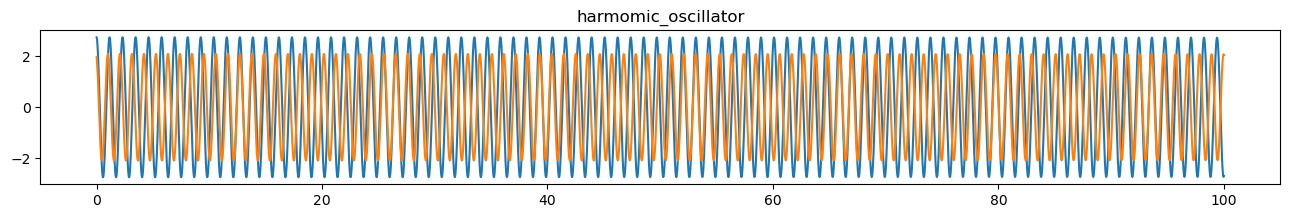

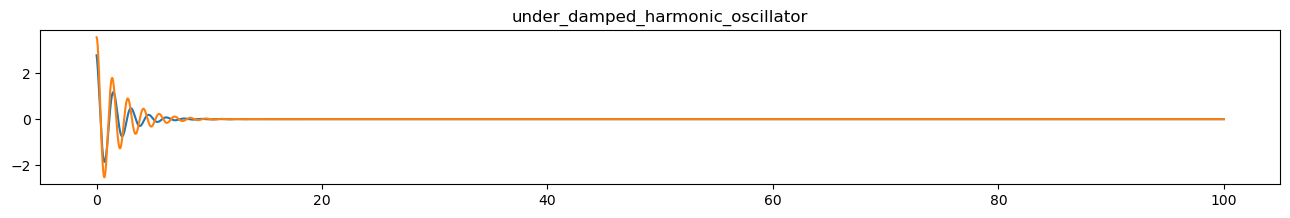

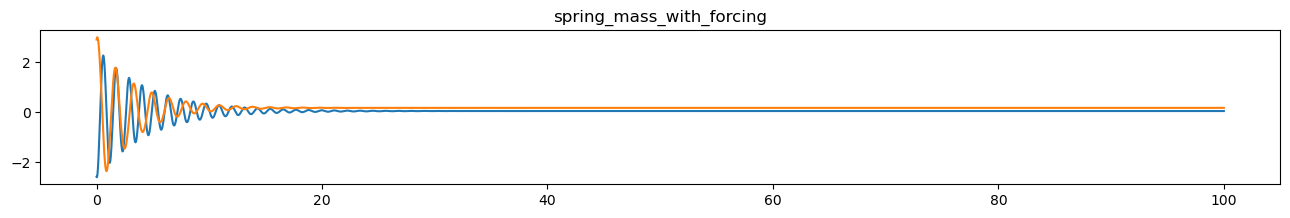

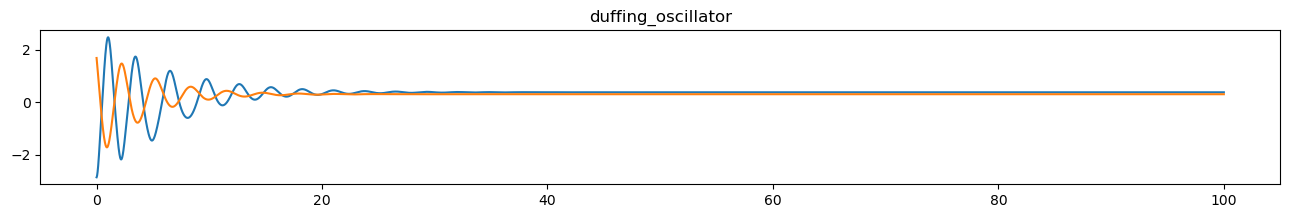

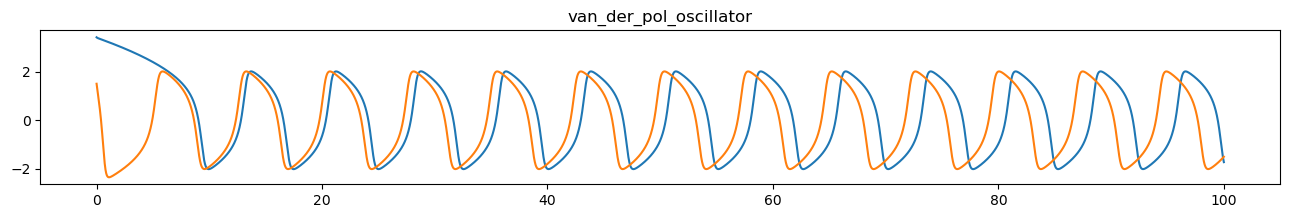

In [27]:
for key in dataset.keys():

    curr_data = dataset[key]
    
    plt.figure(figsize=(16,2))
    for i in range(2):
        x = curr_data[i]['t']
        y = curr_data[i]['y'][0,:].T
        plt.plot(x,y)

    plt.title(key)
    # plt.legend(['x','v'])
    plt.show()